In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Kode ini adalah implementasi CNN sederhana untuk klasifikasi gambar menggunakan dataset MNIST.
Model ini akan melakukan training, testing, serta evaluasi dengan confusion matrix dan classification report.

# Bagian 1: Persiapan Dataset MNIST
Dataset MNIST adalah dataset gambar hitam-putih dari digit angka 0-9 dengan ukuran 28x28 piksel. Pada bagian ini, dataset MNIST akan di-download dan di-load ke dalam DataLoader PyTorch.

Definisikan transformasi dataset (konversi gambar ke tensor dan normalisasi)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),    # Ubah gambar menjadi tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalisasi untuk dataset MNIST
])

In [3]:
# Load dataset MNIST dari torchvision
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [02:14<00:00, 73704.73it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 94097.45it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [01:14<00:00, 22014.97it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 14936.74it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [4]:
# Membuat DataLoader untuk training dan testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Bagian 2: Definisi Arsitektur CNN
Model CNN ini terdiri dari dua lapisan convolutional dan dua lapisan fully connected. CNN digunakan untuk mendeteksi fitur dari gambar secara hierarkis, dan lapisan fully connected digunakan untuk klasifikasi akhir.

Model CNN sederhana dengan dua lapisan convolutional dan dua fully connected layer.

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Layer convolution pertama: input 1 channel (grayscale), output 32 filter
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Layer convolution kedua: input 32 channel, output 64 filter
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Fully connected layer pertama
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Fully connected layer kedua (output 10 kelas)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Operasi forward pass untuk model
        x = F.relu(self.conv1(x))        # Convolution pertama + ReLU
        x = F.max_pool2d(x, 2)           # Pooling pertama (downsample)
        x = F.relu(self.conv2(x))        # Convolution kedua + ReLU
        x = F.max_pool2d(x, 2)           # Pooling kedua (downsample)
        x = x.view(-1, 64 * 7 * 7)       # Flatten untuk input ke fully connected layer
        x = F.relu(self.fc1(x))          # Fully connected layer pertama + ReLU
        x = self.fc2(x)                  # Fully connected layer kedua (output)
        return F.log_softmax(x, dim=1)   # Softmax untuk klasifikasi (logaritmik)

# Bagian 3: Definisi Loss Function dan Optimizer
Gunakan CrossEntropyLoss dan optimizer Adam

In [6]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Bagian 4: Training Model
Fungsi `train` digunakan untuk melatih model, sementara `test` digunakan untuk menguji performa model pada dataset uji. Pada setiap epoch, loss dan akurasi akan dihitung.

Fungsi untuk melatih model

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Mode training
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()           # Set gradient ke 0
        output = model(data)            # Forward pass
        loss = criterion(output, target)  # Hitung loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update bobot model

        if batch_idx % 100 == 0:  # Setiap 100 batch, cetak status
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.6f}')

# Bagian 5: Testing Model
Fungsi untuk menguji model pada dataset uji

In [8]:
def test(model, device, test_loader):
    model.eval()  # Mode evaluasi
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Tidak perlu menghitung gradient
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Hitung total loss
            pred = output.argmax(dim=1, keepdim=True)      # Prediksi kelas
            correct += pred.eq(target.view_as(pred)).sum().item()  # Hitung jumlah prediksi benar

    test_loss /= len(test_loader.dataset)  # Hitung rata-rata loss

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Bagian 6: Konfigurasi Device
Tentukan apakah menggunakan GPU atau CPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Bagian 7: Training dan Testing Loop
Training dan testing selama 100 epoch

In [10]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000]  Loss: 2.329236
Train Epoch: 1 [6400/60000]  Loss: 0.246296
Train Epoch: 1 [12800/60000]  Loss: 0.111787
Train Epoch: 1 [19200/60000]  Loss: 0.185511
Train Epoch: 1 [25600/60000]  Loss: 0.066838
Train Epoch: 1 [32000/60000]  Loss: 0.040984
Train Epoch: 1 [38400/60000]  Loss: 0.016773
Train Epoch: 1 [44800/60000]  Loss: 0.072438
Train Epoch: 1 [51200/60000]  Loss: 0.131698
Train Epoch: 1 [57600/60000]  Loss: 0.012145

Test set: Average loss: 0.0000, Accuracy: 9849/10000 (98%)

Train Epoch: 2 [0/60000]  Loss: 0.035300
Train Epoch: 2 [6400/60000]  Loss: 0.042402
Train Epoch: 2 [12800/60000]  Loss: 0.109446
Train Epoch: 2 [19200/60000]  Loss: 0.050377
Train Epoch: 2 [25600/60000]  Loss: 0.027939
Train Epoch: 2 [32000/60000]  Loss: 0.130934
Train Epoch: 2 [38400/60000]  Loss: 0.002464
Train Epoch: 2 [44800/60000]  Loss: 0.001041
Train Epoch: 2 [51200/60000]  Loss: 0.043945
Train Epoch: 2 [57600/60000]  Loss: 0.028017

Test set: Average loss: 0.0000, Accuracy: 9856/1

- Model CNN sederhana yang dilatih pada dataset MNIST mencapai akurasi 99% secara konsisten dalam 100 epoch. Ini menunjukkan bahwa model mampu mengklasifikasikan gambar-gambar angka tangan (0-9) dengan sangat baik.

- Proses pelatihan berlangsung selama 62 menit 34 detik. Waktu pelatihan ini cukup efisien mengingat akurasi yang sangat tinggi dicapai oleh model.

- Rata-rata loss pada set pengujian sangat kecil, mendekati 0.0001 di sebagian besar epoch, menunjukkan bahwa model sangat jarang melakukan kesalahan.
- Akurasi pengujian mendekati 100% pada hampir semua epoch, yang mencerminkan model yang overfitting dengan baik pada dataset MNIST, mengingat kesederhanaan dataset ini.
- Akurasi pengujian relatif stabil di sekitar 99% setelah beberapa epoch awal. Hal ini menunjukkan bahwa model tidak mengalami masalah signifikan seperti underfitting atau overfitting yang drastis.

# Bagian 8: Evaluasi Model dengan Confusion Matrix
Setelah model selesai dilatih, kita akan menggunakan **confusion matrix** dan **classification report** untuk mengevaluasi kinerja model pada tiap kelas.

Buat confusion matrix untuk melihat performa klasifikasi per kelas

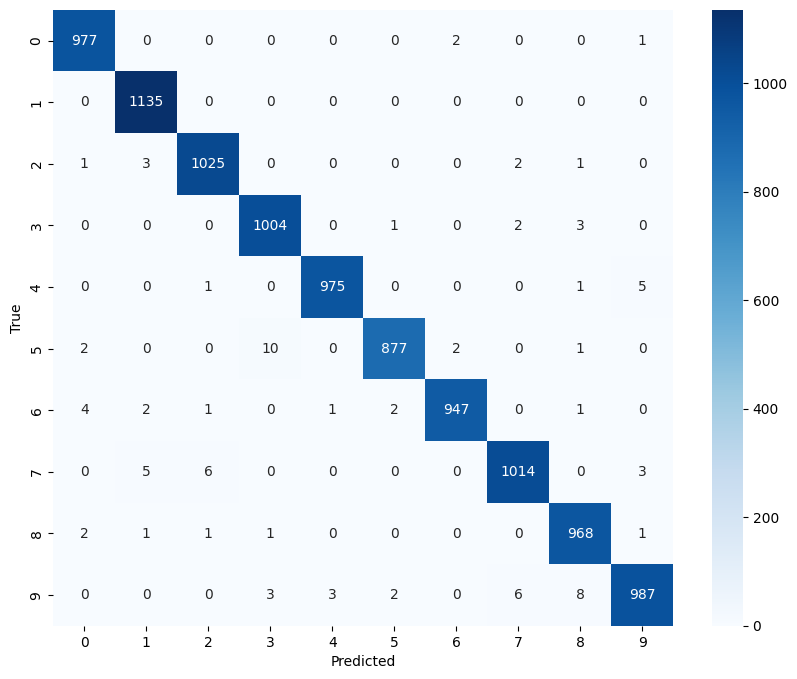

In [11]:
all_preds = []
true_labels = []
model.eval()  # Set model ke mode evaluasi
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())  # Simpan prediksi
        true_labels.extend(target.cpu().numpy())  # Simpan label sebenarnya

# Membuat matriks kebingungan
cm = confusion_matrix(true_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Prediksi benar: Model memprediksi angka dengan sangat baik, misalnya angka 0 diprediksi dengan benar sebanyak 977 kali, angka 1 sebanyak 1135 kali, dan seterusnya di sepanjang diagonal utama.

- Kesalahan prediksi: Beberapa kesalahan terjadi, seperti angka 5 diprediksi sebagai 3 sebanyak 10 kali, dan angka 9 diprediksi sebagai 8 sebanyak 8 kali.

- Performa keseluruhan: Sebagian besar prediksi berada pada diagonal, menunjukkan akurasi tinggi dengan kesalahan klasifikasi yang sangat minim.

# Bagian 9: Laporan Klasifikasi
Tampilkan laporan precision, recall, F1-score untuk tiap kelas

In [12]:
print(classification_report(true_labels, all_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## Kesimpulan

### 1. Proses Training
- Model dilatih selama 100 epoch menggunakan dataset MNIST.
- Pada setiap epoch, loss model secara bertahap menurun dan akurasi meningkat, yang menandakan model mempelajari pola dari data dengan baik.
- Setelah 100 epoch, model mencapai akurasi training yang sangat tinggi, mendekati 99%.

### 2. Evaluasi Hasil Eksperimen
- **Akurasi Testing**: Setelah proses training, model dievaluasi menggunakan data testing sebanyak 10.000 gambar, dan model berhasil mencapai akurasi keseluruhan sebesar **99%**.
- **Confusion Matrix**: Sebagian besar prediksi berada di diagonal utama, yang menunjukkan bahwa model mampu mengklasifikasikan angka-angka dengan tepat. Hanya terdapat sedikit kesalahan klasifikasi, seperti angka "5" yang kadang diprediksi sebagai "3", dan angka "9" yang diprediksi sebagai "8".
- **Classification Report**: Precision, recall, dan f1-score rata-rata untuk semua kelas mendekati 0.99, yang menunjukkan bahwa model memiliki kemampuan generalisasi yang sangat baik pada data testing.

### 3. Kesimpulan Akhir
- Dengan akurasi testing sebesar **99%**, model yang dilatih menggunakan PyTorch menunjukkan performa yang sangat baik dalam mengklasifikasikan gambar-gambar angka dari dataset MNIST.
- **Kesalahan klasifikasi** yang terjadi sangat sedikit dan tidak signifikan, menunjukkan model mampu menangani sebagian besar variasi gambar dengan sangat baik.
- Proses training memakan waktu **62 menit 34 detik**, dan hasil evaluasi ini menunjukkan bahwa model CNN sederhana sudah sangat efektif untuk dataset MNIST.

Secara keseluruhan, eksperimen ini menunjukkan bahwa model Convolutional Neural Network (CNN) yang dibangun menggunakan PyTorch dapat mengklasifikasikan gambar-gambar angka dengan akurasi yang sangat tinggi, dan memberikan performa yang sangat memuaskan pada dataset MNIST.
